In [1]:
%cd ../..

/home/alexkkir/IQA-PyTorch


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
import multiprocessing as mp
import os
import shutil
import subprocess
import sys
from copy import deepcopy
from functools import partial
from io import StringIO
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import torch
from torch import nn

import torchvision.transforms as T
import torchvision.transforms.functional as TF
import yaml
from IPython.display import display
from PIL import Image
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map as tqdm_pool
from time import sleep
import gc

import pyiqa
from files.haled_adv.model import VanillaArch

sns.set_theme()

In [4]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
dataset_root = Path('datasets/nonuniform_dataset')
reference_root = dataset_root / 'reference'
saliency_root = dataset_root / 'saliency'
compressed_root = dataset_root / 'compressed'
tmp_root = Path('tmp')
comp_root = dataset_root / 'comp'

In [6]:
class NonuniformDataset(torch.utils.data.Dataset):
    def __init__(self, reference_root, saliency_root, compessed_root, transforms=None):
        self.reference_root = Path(reference_root)
        self.saliency_root = Path(saliency_root)
        self.compessed_root = Path(compessed_root)

        self.files = list(self._files_iterator())
        self.transforms = transforms

    def _files_iterator(self):
        for seq in os.listdir(self.compessed_root):
            folder = self.compessed_root / seq
            reference = self.reference_root / (seq + ".png")
            saliency = self.saliency_root / (seq + ".png")
            for file in os.listdir(folder):
                yield str(folder / file), str(reference), str(saliency)

    def __len__(self):
        return len(self.files)
    
    def _open_image(self, path):
        image = Image.open(path)
        image = np.array(image).astype('float32') / 255
        if image.ndim == 2:
            image = image[..., np.newaxis]
        return image

    def __getitem__(self, index):
        files = self.files[index]
        filename = files[0]  # compressed
        images = [self._open_image(x) for x in files]
        if self.transforms is not None:
            images = [self.transforms(x) for x in images]
        return *images, filename


dataset = NonuniformDataset(
    reference_root, saliency_root, compressed_root, transforms=None
)
loader = torch.utils.data.DataLoader(dataset, batch_size=1)

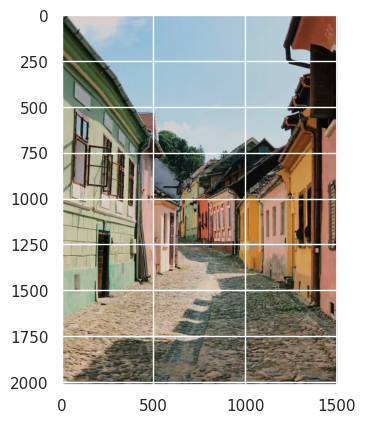

In [7]:
plt.imshow(dataset[0][0])

In [8]:
class VanillaInferenceModel(nn.Module):
    def __init__(self, name, weights_path, is_sal=False, config=None) -> None:
        super().__init__()

        if config is None:
            config = dict(
                saliency_mode="none",
                fusion="none",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            )
        self.model = VanillaArch(**config).eval()
        self.model.load_state_dict(torch.load(weights_path)["params"])

        self.metric_mode = "NR"
        self.metric_name = name
        self.is_sal = is_sal

        self.device = torch.device("cpu")

    def to(self, device):
        super().to(device=device)
        self.device = device

    def forward(self, image, saliency=None):
        image = image.to(self.device)
        if saliency is not None:
            saliency = saliency.to(self.device)
        pred = self.model(image, saliency)
        return pred.pred_score


def get_model(config: dict):
    model_params = config.get("model_params", dict())
    if config["name"] not in pyiqa.list_models():
        # custom
        model = VanillaInferenceModel(name=config["name"], **model_params)
    else:
        model = pyiqa.create_metric(config["name"], **model_params)
    return model

def flush():
    gc.collect()
    torch.cuda.empty_cache()

configs = [
    # ==================== pyiqa fr ====================
    dict(name="psnr", model_params=dict(test_y_channel=True, color_space="ycbcr")),
    dict(name="ssim", model_params=dict(test_y_channel=True, color_space="ycbcr")),
    dict(name="ew_psnr", model_params=dict(test_y_channel=True, color_space="ycbcr")),
    dict(name="ew_ssim", model_params=dict(test_y_channel=True, color_space="ycbcr")),
    dict(name="ms_ssim"),
    dict(name="topiq_fr"),
    dict(name="lpips"),
    dict(name="dists"),
    dict(name="pieapp"),
    dict(name="ahiq"),
    dict(name="vif"),
    # ==================== pyiqa nr ====================
    dict(name="topiq_nr"),
    dict(name="maniqa"),
    dict(name="musiq"),
    dict(name="clipiqa+"),
    dict(name="hyperiqa"),
    dict(name="dbcnn"),
    dict(name="tres"),
    dict(name="paq2piq"),
    dict(name="brisque"),
    # ==================== vanilla gradcam ====================
    dict(
        name="vanilla_baseline",
        model_params=dict(
            weights_path="experiments/024-Baseline/0_2023-12-06_01:42:10/models/net_best.pth",
        ),
    ),
    dict(
        name="vanilla_gradcam",
        model_params=dict(
            weights_path="experiments/024-Gradcam/0_2023-12-06_02:26:33/models/net_best.pth",
        ),
    ),
    dict(
        name="vanilla_corners",
        model_params=dict(
            weights_path="experiments/024-Corners/0_2023-12-06_02:24:52/models/net_best.pth",
        ),
    ),
    dict(
        name="vanilla_vg_hard",
        model_params=dict(
            weights_path="experiments/024-VG-Hard/0_2023-12-06_01:42:10/models/net_best.pth",
        ),
    ),
    dict(
        name="vanilla_vg_soft",
        model_params=dict(
            weights_path="experiments/024-VG-Soft/0_2023-12-06_02:27:04/models/net_best.pth",
        ),
    ),
    dict(
        name="vanilla_salloss",
        model_params=dict(
            weights_path="experiments/024-SalLoss/0_2023-12-06_01:42:10/models/net_best.pth",
            is_sal=False,
            config=dict(
                saliency_mode="output",
                fusion="none",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            ),
        ),
    ),
    # ==================== vanilla adapters ====================
    dict(
        name="vanilla_big_adapter",
        model_params=dict(
            weights_path="experiments/025-BigAdapter/0_2023-12-20_14:09:31/models/net_best.pth",
            is_sal=True,
            config=dict(
                saliency_mode="input",
                fusion="big_adapter",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            ),
        ),
    ),
    dict(
        name="vanilla_multiple_concat",
        model_params=dict(
            weights_path="experiments/025-MultipleConcat/0_2023-12-20_15:10:33/models/net_best.pth",
            is_sal=True,
            config=dict(
                saliency_mode="input",
                fusion="multiple_concat",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            ),
        ),
    ),
    dict(
        name="vanilla_multiple_concat_pretrained",
        model_params=dict(
            weights_path="experiments/025-MultipleConcatPretrained/0_2023-12-20_15:07:40/models/net_best.pth",
            is_sal=True,
            config=dict(
                saliency_mode="input",
                fusion="multiple_concat",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            ),
        ),
    ),
    dict(
        name="vanilla_multiply",
        model_params=dict(
            weights_path="experiments/025-Multiply/1_2023-12-20_14:29:53/models/net_best.pth",
            is_sal=True,
            config=dict(
                saliency_mode="input",
                fusion="multiply",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            ),
        ),
    ),
    dict(
        name="vanilla_output_fuse",
        model_params=dict(
            weights_path="experiments/025-OutputFuse/0_2023-12-20_15:48:12/models/net_best.pth",
            is_sal=True,
            config=dict(
                saliency_mode="output",
                fusion="multiply",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            ),
        ),
    ),
    dict(
        name="vanilla_output_nofuse",
        model_params=dict(
            weights_path="experiments/025-OutputNoFuse/0_2023-12-20_14:29:52/models/net_best.pth",
            is_sal=True,
            config=dict(
                saliency_mode="output",
                fusion="none",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            ),
        ),
    ),
    dict(
        name="vanilla_ritm",
        model_params=dict(
            weights_path="experiments/025-Ritm/0_2023-12-20_17:25:56/models/net_best.pth",
            is_sal=True,
            config=dict(
                saliency_mode="input",
                fusion="ritm_like",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            ),
        ),
    ),
    dict(
        name="vanilla_ritm_pretrained",
        model_params=dict(
            weights_path="experiments/025-RitmPretrained/0_2023-12-20_17:26:11/models/net_best.pth",
            is_sal=True,
            config=dict(
                saliency_mode="input",
                fusion="ritm_like",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            ),
        ),
    ),
    dict(
        name="vanilla_small_adapter",
        model_params=dict(
            weights_path="experiments/025-SmallAdapter/1_2023-12-20_14:29:52/models/net_best.pth",
            is_sal=True,
            config=dict(
                saliency_mode="input",
                fusion="small_adapter",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            ),
        ),
    ),
    dict(
        name="vanilla_small_adapter_pretrained",
        model_params=dict(
            weights_path="experiments/025-SmallAdapterPretrained/0_2023-12-20_15:35:35/models/net_best.pth",
            is_sal=True,
            config=dict(
                saliency_mode="input",
                fusion="small_adapter",
                gradcam_mode="none",
                calculate_gradcam_in_eval_mode=False,
            ),
        ),
    ),
]

configs = [
    # ==================== pyiqa fr ====================
    dict(name="psnr", model_params=dict(test_y_channel=True, color_space="ycbcr")),
    dict(name="ssim", model_params=dict(test_y_channel=True, color_space="ycbcr")),
]

In [9]:
from torchvision.transforms.functional import InterpolationMode


class AdaptiveResize(T.Resize):
    def __init__(self, size, interpolation=InterpolationMode.BILINEAR, max_size=None, antialias="warn"):
        super().__init__(size, interpolation, max_size, antialias)
        self.inv_size = self.size[::-1]

    def forward(self, img):
        if img.shape[1] > img.shape[2]:
            if self.size[0] > self.size[1]:
                return TF.resize(img, self.size, self.interpolation, self.max_size, self.antialias)
            else:
                return TF.resize(img, self.inv_size, self.interpolation, self.max_size, self.antialias)
        else:
            if self.size[0] > self.size[1]:
                return TF.resize(img, self.inv_size, self.interpolation, self.max_size, self.antialias)
            else:
                return TF.resize(img, self.size, self.interpolation, self.max_size, self.antialias)
            
class AdaptiveHorizontalResize(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, img):
        if img.shape[1] < img.shape[2]:
            return img
        else:
            return img.permute(0, 2, 1)

In [10]:
transforms = dict(
    full_res=T.Compose([
        T.ToTensor()
    ]),
    resize_384=T.Compose([
        T.ToTensor(),
        T.Resize((384)),
    ]),
    resize_384_512_or_512_384=T.Compose([
        T.ToTensor(),
        AdaptiveResize((384, 512)),
    ]),
    resize_384_512_or_512_384_horizontal=T.Compose([
        T.ToTensor(),
        AdaptiveResize((384, 512)), 
        AdaptiveHorizontalResize(),
    ]),
)

datasets = {
    k: NonuniformDataset(reference_root, saliency_root, compressed_root, transforms=v) 
    for k, v in transforms.items()
}

In [11]:
dataset = NonuniformDataset(
    reference_root, saliency_root, compressed_root, transforms=transforms['full_res']
)
print(pyiqa.create_metric('psnr', test_y_channel=True, color_space="ycbcr")(dataset[0][0].unsqueeze(0), dataset[0][1].unsqueeze(0)))
print(pyiqa.create_metric('ew_psnr', test_y_channel=True, color_space="ycbcr")(dataset[0][0].unsqueeze(0), dataset[0][1].unsqueeze(0), dataset[0][2].unsqueeze(0)))
print(pyiqa.create_metric('ssim', test_y_channel=True, color_space="ycbcr")(dataset[0][0].unsqueeze(0), dataset[0][1].unsqueeze(0)))
print(pyiqa.create_metric('ew_ssim', test_y_channel=True, color_space="ycbcr")(dataset[0][0].unsqueeze(0), dataset[0][1].unsqueeze(0), dataset[0][2].unsqueeze(0)))

tensor([28.6333], device='cuda:0')
tensor([28.1146], device='cuda:0')
tensor([0.8484], device='cuda:0')
tensor([0.8420], device='cuda:0')


/home/alexkkir/miniconda3/envs/pyiqa/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


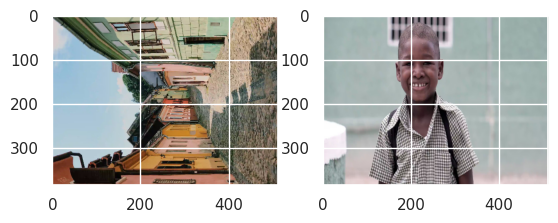

In [12]:
dataset = NonuniformDataset(
    reference_root, saliency_root, compressed_root, transforms=transforms['resize_384_512_or_512_384_horizontal']
)

plt.subplot(1, 2, 1)
plt.imshow(dataset[0][0].permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(dataset[36][0].permute(1, 2, 0))

In [13]:
def test_resize_384_512_or_512_384():
    dataset = NonuniformDataset(
        reference_root, saliency_root, compressed_root, transforms=transforms['resize_384_512_or_512_384']
    )
    exists_384_512 = False
    exists_512_384 = False


    for i in range(len(dataset)):
        shape = dataset[i][0].shape
        if shape == (3, 384, 512):
            exists_384_512 = True
        elif shape == (3, 512, 384):
            exists_512_384 = True
        else:
            raise ValueError

    assert exists_512_384 and exists_384_512

def test_resize_384_512_or_512_384_horizontal():
    dataset = NonuniformDataset(
        reference_root, saliency_root, compressed_root, transforms=transforms['resize_384_512_or_512_384_horizontal']
    )
    for i in range(len(dataset)):
        shape = dataset[i][0].shape
        assert shape == (3, 384, 512)

# test_resize_384_512_or_512_384()
# test_resize_384_512_or_512_384_horizontal()

In [14]:
def main_loop(configs, datasets, debug=False):
    all_results = []
    for config in tqdm(configs):
        metric = get_model(config)
        metric.to(DEVICE)
        for dataset_name, dataset in datasets.items():
            for i, (comp, ref, sal, filename) in enumerate(dataset):
                comp = comp.unsqueeze(0)
                ref = ref.unsqueeze(0)
                sal = sal.unsqueeze(0)

                with torch.no_grad():
                    if metric.metric_mode == 'FR':
                        if metric.is_sal:
                            score = metric(comp, ref, sal)
                        else:
                            score = metric(comp, ref)
                    else:
                        if metric.is_sal:
                            score = metric(comp, sal)
                        else:
                            score = metric(comp)
                score = score.item()

                all_results.append(dict(
                    metric=config['name'],
                    dataset=dataset_name,
                    metric_mode=metric.metric_mode,
                    is_sal=metric.is_sal,
                    score=score,
                    filename=filename
                ))

                if debug and i == 2:
                    break
        metric.cpu()
        del metric
        flush()
    return pd.DataFrame(all_results)

results = main_loop(configs, datasets, debug=True)

100%|██████████| 2/2 [00:05<00:00,  2.74s/it]


In [15]:
results

,metric,dataset,metric_mode,is_sal,score,filename
0,psnr,full_res,FR,False,28.633266,datasets/nonuniform_dataset/compressed/jan-hen...
1,psnr,full_res,FR,False,28.195068,datasets/nonuniform_dataset/compressed/jan-hen...
2,psnr,full_res,FR,False,27.634594,datasets/nonuniform_dataset/compressed/jan-hen...
3,psnr,resize_384,FR,False,30.471588,datasets/nonuniform_dataset/compressed/jan-hen...
4,psnr,resize_384,FR,False,29.870003,datasets/nonuniform_dataset/compressed/jan-hen...
5,psnr,resize_384,FR,False,29.199909,datasets/nonuniform_dataset/compressed/jan-hen...
6,psnr,resize_384_512_or_512_384,FR,False,30.481462,datasets/nonuniform_dataset/compressed/jan-hen...
7,psnr,resize_384_512_or_512_384,FR,False,29.864672,datasets/nonuniform_dataset/compressed/jan-hen...
8,psnr,resize_384_512_or_512_384,FR,False,29.252806,datasets/nonuniform_dataset/compressed/jan-hen...
9,psnr,resize_384_512_or_512_384_horizontal,FR,False,30.481462,datasets/nonuniform_dataset/compressed/jan-hen...


In [16]:
results.to_csv('notebooks/subj_analyzis/9-all-metrics.csv', index=False)

In [17]:
! pwd

/home/alexkkir/IQA-PyTorch
